# Explanation of Cosmological Parameters Calculation

## Summary
In this notebook, we will outline our procedure for calculating the cosmological parameters $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$ from observations of Type 1a supernovae. We will start with datasets describing supernovae redshifts and luminosity distances from several important papers on the topic. We will derive an equation relating redshift and luminosity distance in terms of the cosmological parameters. Then we will fit out data to this model in order to solve for the best fit values of $\Omega_{m,0}$, $\Omega_{\Lambda,0}$, and $H_0$. We will conclude by comparing our parameters to the accepted results and discussing the implications of these parameters for the history and fate of our universe.

## Preliminaries
Let's start by importing the packages we will need, defining the relevant constants, and reading in the redshift and luminosity distance data.

In [1]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv

In [2]:
# constant
c = 2.99792458 * 1e5 # units: km/s

In [3]:
# replace this with import of actual data
# this temporary data comes from Riess et al. (1998)
""""
redshift = np.array([0.43,0.62,0.57,0.30,0.38,0.43,0.44,0.50,0.97,0.48,0.30,0.23,0.16,0.24,0.17,0.83])
dist_mod = np.array([41.74,42.98,42.76,41.38,41.63,42.55,41.95,42.40,44.39,42.45,40.74,40.33,39.08,40.68,39.95,43.67])
dist_mod_err = np.array([0.28,0.17,0.19,0.24,0.20,0.25,0.17,0.17,0.30,0.17,0.60,0.46,0.40,0.43,0.24,0.35])
lum_dist = 10**((dist_mod - 25)/5)
lum_dist_err = lum_dist * np.log(10) * dist_mod_err/5
""""

In [3]:
# read redshift and luminosity distance data from file
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

d_arr = np.array(d)
redshift = np.array(d_arr[:,1], float)
dist_mod = np.array(d_arr[:,2], float)
dist_mod_err = np.array(d_arr[:,3], float)
lum_dist = 10**((dist_mod - 25)/5)
lum_dist_err = lum_dist * np.log(10) * dist_mod_err/5

## Model
In general, a light source's flux, luminosity, and distance are related by
$$F=\frac{L}{4\pi r^2}$$

When doing cosmology, we must make a few modifications to this simple equation to account for the expansion and (possible) curvature of the universe. First, since the universe may not be flat, the area over which the source's light spreads out is $A=4\pi S_k(r)^2$ where
$$S_k(r) = \begin{cases}
    R_0\sin{\left(\frac{r}{R_0}\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    R_0\sinh{\left(\frac{r}{R_0}\right)}, & \kappa = -1\\
\end{cases}$$

and $R_0$ is the universe's radius of curvature. As expected, this expression simplifies to $A=4\pi r^2$ in the case of a flat universe.

Next, because the universe is expanding, the wavelength at which we observe a photon is longer than the wavelength at which it was emitted. In particular, a photon emitted with wavelength $\lambda_e$ and energy $E_e = \frac{hc}{\lambda_e}$ will have wavelength $\lambda_o = \frac{\lambda_e}{a(t_e)}$ and energy 
$$E_o = \frac{hc}{\lambda_o} = a(t_e) \frac{hc}{\lambda_e} = a(t_e)E_e = \frac{1}{1+z_e}E_e$$

when we observe it today. We can account for this by adding a factor of $\frac{1}{1+z_e}$ to the expression for the observed flux; that is,
$$F=\frac{L}{4\pi S_k(r)^2}\frac{1}{1+z_e}$$

We are not quite done yet, because we still need to incorporate the effect of cosmological time dilation. If two photons are emitted a time $\Delta t_e$ apart, then the time interval between when we observe the two photons is
$$\Delta t_o = \frac{a(t_o)}{a(t_e)}\Delta t_e = \frac{\Delta t_e}{a(t_e)} = (1+z_e)\Delta t_e$$

This means the observed flux is a factor of $\frac{1}{1+z_e}$ smaller than we previously calculated, seeing as the time interval between the arrival of successive photons is larger. Hence our final expression for the relationship between flux, luminosity, and distance (which now also depends on redshift) is
$$F = \frac{L}{4\pi S_k(r)^2}\frac{1}{(1+z_e)^2}$$

This expression can be simplified by defining the $\textbf{luminosity distance}$ $d_L = S_k(r)(1+z_e)$ such that $F = \frac{L}{4\pi d_L^2}$. This relation almost gives us the desired expression relating $d_L$ and $z$, except that we need to know the comoving radial coordinate $r$. From the Friedmann-Robertson-Walker (FRW) metric for light moving radially inward, we can see that
$$ds^2 = 0 = -c^2dt^2 + a(t)^2dr^2$$
$$ dr^2 = c^2\frac{dt^2}{a(t)^2}$$
$$ dr = -c\frac{dt}{a(t)}$$
$$r = -\int_r^0 dr' = c\int_{t_e}^{t_0}\frac{dt}{a(t)} = c\int_{t_e}^{t_0}\frac{dt}{da}\frac{da}{a} = c\int_{a(t_e)}^{1}\frac{da}{\dot{a}a} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{a}{\dot{a}} = c\int_{a(t_e)}^{1}\frac{da}{a^2}\frac{1}{H(t)}$$

At this point, we can use the Friedmann equation for a matter- and dark energy-dominated universe to replace the Hubble parameter:
$$H(t)^2 = \frac{\dot{a}^2}{a^2} = H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)$$
$$r=c\int_{a(t_e)}^{1}\frac{da}{a^2}\left[H_0^2 \left(\frac{\Omega_{m,0}}{a^3} + \Omega_{\Lambda,0}+\frac{1-\Omega_0}{a^2}\right)\right]^{-\frac{1}{2}}$$

We now need to convert the integration over the scale factor into an integration over the redshift. This can be accomplished using the relation $a = \frac{1}{1+z}$ and $da = -\frac{dz}{(1+z)^2}$.
$$r=-c\int_{z_e}^{0}\frac{dz}{(1+z)^2}(1+z)^2\left[H_0^2 \left({\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right)\right]^{-\frac{1}{2}}=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_0\right)(1+z)^2\right]^{-\frac{1}{2}}dz$$

In a matter- and dark energy-dominated universe, $\Omega_0 = \Omega_{m,0} + \Omega_{\Lambda,0}$. We can use this to simplify further:
\begin{aligned}
r&=cH_0^{-1}\int_0^{z_e}\left[{\Omega_{m,0}}(1+z)^3 + \Omega_{\Lambda,0}+\left(1-\Omega_{m,0}-\Omega_{\Lambda,0}\right)(1+z)^2\right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left(\Omega_{m,0} + \Omega_{m,0}z- \Omega_{m,0}\right) + \Omega_{\Lambda,0}+(1+z)^2 - \Omega_{\Lambda,0}(1+z)^2 \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) + \Omega_{\Lambda,0}\left(1-1-2z-z^2\right) \right]^{-\frac{1}{2}}dz\\
&=cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz
\end{aligned}

We can now insert this expression into our equation for the luminosity distance.
$$d_L = S_k(r)(1+z_e) = (1+z_e)S_k\left(cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)$$

To evaluate the $S_k(r)$ function, we will need to derive an expression for the radius of curvature $R_0$. In Problem Set 6, we derived that $R_0$ satisfies the equation
$$\frac{\kappa}{R_0^2} = \frac{H_0^2}{c^2}(\Omega_0-1)$$
$$R_0^2 = \frac{\kappa c^2}{H_0^2}\frac{1}{{\Omega_0 - 1}}$$

Notice that this expression for $R_0$ is always nonnegative because $\Omega_0 > 1$ when $\kappa = +1$ and $\Omega_0 < 1$ when $\kappa = -1$. We can use this to rewrite the function $S_k(r)$ in the following form.
$$S_k(r) = \begin{cases}
    \frac{c}{H_0}\frac{1}{\sqrt{\Omega_0 -1}}\sin{\left(\frac{H_0}{c}\sqrt{\Omega_0 -1}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\frac{1}{\sqrt{1-\Omega_0}}\sinh{\left(\frac{H_0}{c}\sqrt{1-\Omega_0}r\right)}, & \kappa = -1\\
\end{cases}$$

Let's now define $\Omega_k = 1-\Omega_0$ and $\text{sinn}(x) = \begin{cases} \sin{(x)}, & \kappa = +1\\ x, & \kappa = 0\\ \sinh{(x)}, & \kappa = -1\\\end{cases}$. Then our expression for $S_k(r)$ can be further simplified to
\begin{aligned}
S_k(r) &= \begin{cases}
    \frac{c}{H_0}\vert\Omega_k\vert^{-\frac{1}{2}}\sin{\left(\frac{H_0}{c}\vert\Omega_k\vert^{\frac{1}{2}}r\right)}, & \kappa = +1\\
    r, & \kappa = 0\\
    \frac{c}{H_0}\vert\Omega_k\vert^{-\frac{1}{2}}\sinh{\left(\frac{H_0}{c}\vert\Omega_k\vert^{\frac{1}{2}}r\right)}, & \kappa = -1\\
\end{cases}\\
&= \frac{c}{H_0}\vert\Omega_k\vert^{-\frac{1}{2}}\text{sinn}{\left(\frac{H_0}{c}\vert\Omega_k\vert^{\frac{1}{2}}r\right)}
\end{aligned}

Inserting this expression into the equation for the luminosity distance, we obtain
\begin{aligned}
d_L &= (1+z_e)\frac{c}{H_0}\vert\Omega_k\vert^{-\frac{1}{2}}\text{sinn}\left(\frac{H_0}{c}\vert\Omega_k\vert^{\frac{1}{2}}cH_0^{-1}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)\\
&=cH_0^{-1}(1+z_e)\vert\Omega_k\vert^{-\frac{1}{2}}\text{sinn}\left(\vert\Omega_k\vert^{\frac{1}{2}}\int_0^{z_e}\left[(1+z)^2 \left( 1+\Omega_{m,0}z\right) -z(2+z) \Omega_{\Lambda,0} \right]^{-\frac{1}{2}}dz\right)
\end{aligned}

This last line is exactly Equation (2) from Riess et al. (1998), so we have just derived the equation used to fit cosmological parameters in one of the original papers on the accelerating universe! Let's now write a Python function to compute the expression on the right side of this equation.

In [4]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

## Fitting Model to Data
To solve for the cosmological parameters, we will fit our luminosity distance and redshift data to the function ``D_L()`` using SciPy's curve_fit function.

In [5]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [55]:
bnds = ((0,0,60),(2,2,80))
popt, pcov = opt.curve_fit(D_L_helper, redshift, lum_dist, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err)
omega_m, omega_lambda, H_0 = popt
omega_m_err, omega_lambda_err, H_0_err = np.sqrt(np.diag(pcov))

In [56]:
print("Matter density: ", "{0:.3f}".format(omega_m), " ± ", "{0:.3f}".format(omega_m_err))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda), " ± ", "{0:.2f}".format(omega_lambda_err))
print("Hubble constant: ", "{0:.2f}".format(H_0), " ± ", "{0:.2f}".format(H_0_err))

Matter density:  0.323  ±  0.069
Dark energy density:  0.75  ±  0.11
Hubble constant:  70.49  ±  0.43


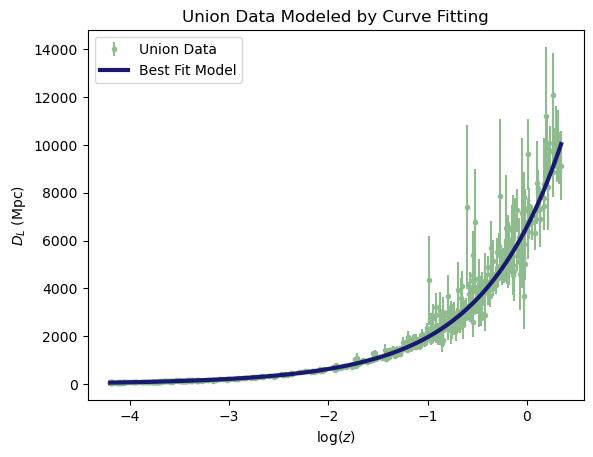

In [58]:
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='darkseagreen')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m, omega_lambda, H_0), linewidth=3,color='midnightblue')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Union Data Modeled by Curve Fitting");

Possibly add zoomed-in version of plot at high redshift?

## Phase Space Sampling
An alternative method for finding the best fit values of the cosmological parameters is to uniformly sample the phase space and identify which combination of parameters provides the best fit to the data. We will sample from the following ranges for the cosmological parameters.
$$ \Omega_{m,0} \in [0,1], \quad \Omega_{\Lambda,0} \in [0,1], \quad H_0 \in [60,80]$$

To evaluate the goodness of fit for each possible combination of parameters, we will compute the chi-squared statistic, which is defined by
$$\chi^2 = \sum_i \frac{(d_{obs,i}-d_{exp,i})^2}{d_{err,i}^2}$$

where the observed luminosity distances are $d_{obs,i}\pm d_{err,i}$, the expected luminosity distances (based on our choice of cosmological parameters) are $d_{exp,i}$, and the sum is taken over all data points.

In [52]:
num_points = 20

omega_m_range = np.linspace(0,1.25,num_points)
omega_lambda_range = np.linspace(0,1.25,num_points)
H_0_range = np.linspace(60,80,num_points)

omega_m_best = omega_m_range[0]
omega_lambda_best = omega_lambda_range[0]
H_0_best = H_0_range[0]
expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
chi2_best = np.sum((lum_dist - expected)**2/lum_dist_err**2)
k_best = 0

chi2_arr = np.zeros((num_points,num_points,num_points))

for i in np.arange(np.size(omega_m_range)):
    for j in np.arange(np.size(omega_lambda_range)):
        for k in np.arange(np.size(H_0_range)):
            omega_m = omega_m_range[i]
            omega_lambda = omega_lambda_range[j]
            H_0 = H_0_range[k]
            expected = D_L_helper(redshift, omega_m, omega_lambda, H_0)
            chi2 = np.sum((lum_dist - expected)**2/lum_dist_err**2)
            chi2_arr[i][j][k] = chi2
            if chi2 < chi2_best:
                omega_m_best = omega_m
                omega_lambda_best = omega_lambda
                H_0_best = H_0
                chi2_best = chi2
                k_best = k
                
print("Matter density: ", "{0:.2f}".format(omega_m_best))
print("Dark energy density: ", "{0:.2f}".format(omega_lambda_best))
print("Hubble constant: ", "{0:.2f}".format(H_0_best))

/var/folders/sr/g5sjm4bd55nbc1x4wnqb1dqw0000gn/T/ipykernel_96584/3745108747.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
/var/folders/sr/g5sjm4bd55nbc1x4wnqb1dqw0000gn/T/ipykernel_96584/3745108747.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(integrand,0,z)[0]


Matter density:  0.33
Dark energy density:  0.79
Hubble constant:  70.53


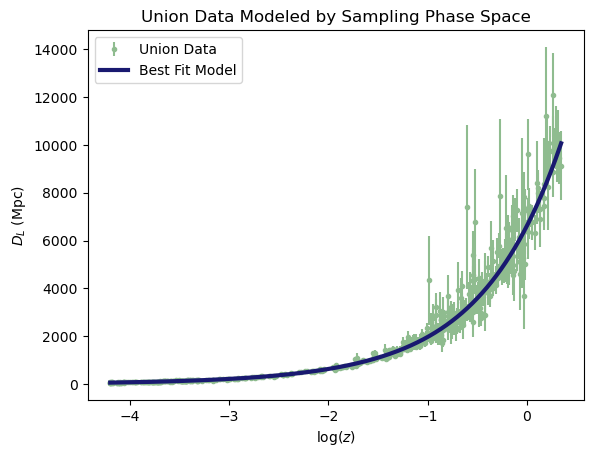

In [60]:
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.errorbar(np.log(redshift),lum_dist,yerr=lum_dist_err,fmt='.',color='darkseagreen')
plt.errorbar(np.log(zz),D_L_helper(zz, omega_m_best, omega_lambda_best, H_0_best), linewidth=3,color='midnightblue')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(("Union Data","Best Fit Model"),loc='upper left')
plt.title("Union Data Modeled by Sampling Phase Space");

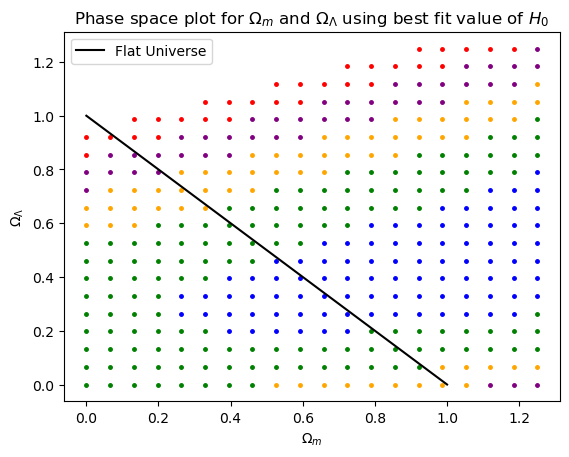

In [69]:
chi2_slice = chi2_arr[:][:][k]
reduced_chi2_slice = chi2_slice / (np.size(redshift) - 3)

for i in np.arange(np.size(omega_m_range)):
    for j in np.arange(np.size(omega_lambda_range)):
        if reduced_chi2_slice[i][j] <= 2:
            plt.plot(omega_m_range[i],omega_lambda_range[j],'.',markersize=5,color='b',label='_nolegend_')
        elif reduced_chi2_slice[i][j] <= 3:
            plt.plot(omega_m_range[i],omega_lambda_range[j],'.',markersize=5,color='g',label='_nolegend_')
        elif reduced_chi2_slice[i][j] <= 4:
            plt.plot(omega_m_range[i],omega_lambda_range[j],'.',markersize=5,color='orange',label='_nolegend_')
        elif reduced_chi2_slice[i][j] <= 5:
            plt.plot(omega_m_range[i],omega_lambda_range[j],'.',markersize=5,color='purple',label='_nolegend_')
        elif reduced_chi2_slice[i][j] <= 6:
            plt.plot(omega_m_range[i],omega_lambda_range[j],'.',markersize=5,color='red',label='_nolegend_')

plt.plot(np.array([0,1]),1-np.array([0,1]),color='black',label='Flat Universe')
plt.xlabel("$\Omega_m$")
plt.ylabel("$\Omega_{\Lambda}$")
plt.title("Phase space plot for $\Omega_m$ and $\Omega_{\Lambda}$ using best fit value of $H_0$")
plt.legend();

Still want to improve this plot further: figure out how to explicitly show 95%, etc. confidence intervals and draw ellipses rather than dots

## Scale Factor Integration

## Discussion of Results

## References
Ryden, B. Introduction to Cosmology. Addison Wesley, 2003.

Riess, A. G., et al. 1998, Astron. J., 116, 1009.